In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import numpy as np

print(os.getcwd())
df_train = pd.read_csv("../codebert/train_data.csv")
df_test = pd.read_csv("../codebert/test_data.csv")

print("Train DataFrame:")
print(df_train.head())
print("Columns:", df_train.columns.tolist())
print("\nTest DataFrame:")
print(df_test.head())
print("Columns:", df_test.columns.tolist())

/Users/rita/Documents/9309_ML/Smart_Contract_Vulnerabilities_Project/Model Training
Train DataFrame:
   vulnerability_exists           vulnerability_list  \
0                     0  [1, 0, 0, 0, 0, 0, 0, 0, 0]   
1                     1  [0, 0, 0, 0, 0, 0, 0, 1, 0]   
2                     0  [1, 0, 0, 0, 0, 0, 0, 0, 0]   
3                     1  [0, 0, 0, 0, 0, 0, 0, 1, 0]   
4                     0  [1, 0, 0, 0, 0, 0, 0, 0, 0]   

                              features_list_codebert  
0  [ 1.24513000e-01 -2.69861996e-01 -2.88200080e-...  
1  [ 9.27233920e-02 -2.72324622e-01 -3.53776157e-...  
2  [ 6.29609600e-02 -2.30400190e-01 -3.58148873e-...  
3  [ 1.14520445e-01 -2.00031653e-01 -3.54265928e-...  
4  [ 1.24746501e-01 -2.72341669e-01 -2.81437218e-...  
Columns: ['vulnerability_exists', 'vulnerability_list', 'features_list_codebert']

Test DataFrame:
   vulnerability_exists           vulnerability_list  \
0                     1  [0, 0, 0, 0, 0, 1, 0, 0, 0]   
1                    

In [2]:
def parse_features_list(features_str):
    cleaned_str = features_str.strip().strip('[]').replace('\n', ' ').strip()
    features_list = [float(x) for x in cleaned_str.split() if x]
    return np.array(features_list, dtype=np.float32)

X_train = np.stack(df_train['features_list_codebert'].apply(parse_features_list).values)
X_test = np.stack(df_test['features_list_codebert'].apply(parse_features_list).values)

y_train = df_train['vulnerability_exists'].values
y_test = df_test['vulnerability_exists'].values

# 轉為 PyTorch Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # [N] -> [N, 1]
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 驗證形狀
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

torch.save(X_train, "../codebert/X_train.pt")
torch.save(X_test, "../codebert/X_test.pt")

X_train shape: torch.Size([4294, 768])
y_train shape: torch.Size([4294, 1])
X_test shape: torch.Size([1074, 768])
y_test shape: torch.Size([1074, 1])


In [3]:
class VulnScreener(nn.Module):
    def __init__(self):
        super(VulnScreener, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(768, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.mlp(x)

def compute_metrics(outputs, y_true, T):
    predictions = (outputs >= T).float()
    TP = torch.sum((predictions == 1) & (y_true == 1)).float()
    FN = torch.sum((predictions == 0) & (y_true == 1)).float()
    FP = torch.sum((predictions == 1) & (y_true == 0)).float()
    TN = torch.sum((predictions == 0) & (y_true == 0)).float()
    epsilon = 1e-7
    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    fnr = FN / (TP + FN + epsilon)
    fpr = FP / (FP + TN + epsilon)
    return {"accuracy": accuracy.item(), "precision": precision.item(), "recall": recall.item(),
            "f1": f1.item(), "fnr": fnr.item(), "fpr": fpr.item(),"T": T}

def train_vuln_screener(X_train, y_train, epochs=400):
    model = VulnScreener()
    pos_weight = ((y_train.shape[0] - y_train.sum()) / y_train.sum() * 1.5).clone().detach()  # 修正正類權重計算
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)  # 加強 L2 正則化
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
    T = 0.0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            model.eval()
            with torch.no_grad():
                train_probs = torch.sigmoid(outputs)
                metrics = compute_metrics(train_probs, y_train, 0.5)
                fnr, fpr = metrics["fnr"], metrics["fpr"]
                if fnr > 0.02:  # 更嚴格的 FNR 目標
                    T = max(-1.0, T - 0.5)
                elif fpr > 0.05:  # 更嚴格的 FPR 目標
                    T = min(1.0, T + 0.5)
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}, T: {T:.2f}, Train Acc: {metrics['accuracy']:.4f}, FPR: {fpr:.4f}")

        scheduler.step(loss)

    return model, T

# 測試第一個模型
def test_vuln_screener(model, X_test, y_test, T):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_probs = torch.sigmoid(test_outputs)
        metrics = compute_metrics(test_probs, y_test, 0.5)
    print("\nFirst Model - Final testing result (T=0.5):")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    return test_outputs


In [4]:
# Training and testing
model, T = train_vuln_screener(X_train, y_train)
test_outputs = test_vuln_screener(model, X_test, y_test, T)

Epoch 0, Loss: 0.9790, T: -0.50, Train Acc: 0.4928, FPR: 0.4857
Epoch 5, Loss: 0.5343, T: -1.00, Train Acc: 0.8074, FPR: 0.2745
Epoch 10, Loss: 0.4535, T: -1.00, Train Acc: 0.8333, FPR: 0.2524
Epoch 15, Loss: 0.4124, T: -1.00, Train Acc: 0.8484, FPR: 0.2333
Epoch 20, Loss: 0.3798, T: -1.00, Train Acc: 0.8638, FPR: 0.2026
Epoch 25, Loss: 0.3524, T: -1.00, Train Acc: 0.8724, FPR: 0.1931
Epoch 30, Loss: 0.3379, T: -1.00, Train Acc: 0.8789, FPR: 0.1831
Epoch 35, Loss: 0.3166, T: -1.00, Train Acc: 0.8840, FPR: 0.1810
Epoch 40, Loss: 0.2918, T: -1.00, Train Acc: 0.8924, FPR: 0.1662
Epoch 45, Loss: 0.2746, T: -1.00, Train Acc: 0.9008, FPR: 0.1528
Epoch 50, Loss: 0.2578, T: -1.00, Train Acc: 0.9034, FPR: 0.1498
Epoch 55, Loss: 0.2376, T: -1.00, Train Acc: 0.9190, FPR: 0.1229
Epoch 60, Loss: 0.2221, T: -1.00, Train Acc: 0.9227, FPR: 0.1177
Epoch 65, Loss: 0.2087, T: -1.00, Train Acc: 0.9304, FPR: 0.0978
Epoch 70, Loss: 0.1907, T: -1.00, Train Acc: 0.9367, FPR: 0.0922
Epoch 75, Loss: 0.1752, T: 

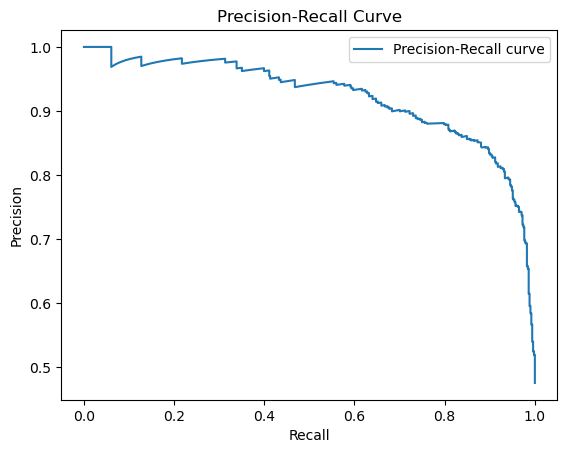

In [5]:
precision, recall, thresholds = precision_recall_curve(y_test.numpy(), test_outputs.numpy())
plt.plot(recall, precision, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

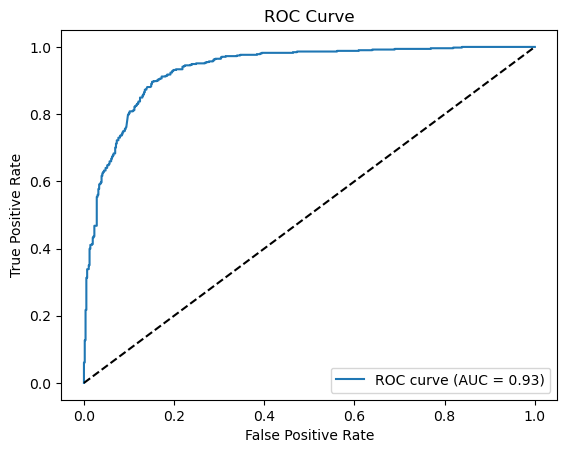

In [6]:
fpr, tpr, _ = roc_curve(y_test.numpy(), test_outputs.numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

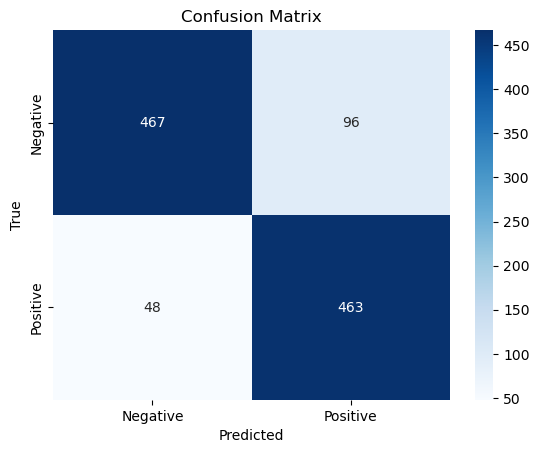

In [7]:
predictions = (test_outputs >= T).float().numpy()
cm = confusion_matrix(y_test.numpy(), predictions)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [8]:
torch.save(model, '../codebert/vuln_screener_model.pth')